### Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

### Reading in data

In [29]:
train = pd.read_csv("../Dataset/Train.csv")
test = pd.read_csv("../Dataset/Test.csv")

### Feature Extraction (Counts)

In [30]:
import importlib
import feature_extraction
importlib.reload(feature_extraction)
from feature_extraction import *

y_train, X_train, y_test, X_test = get_counts(train, test, 3, (1, 1))

### Baseline XGB Model

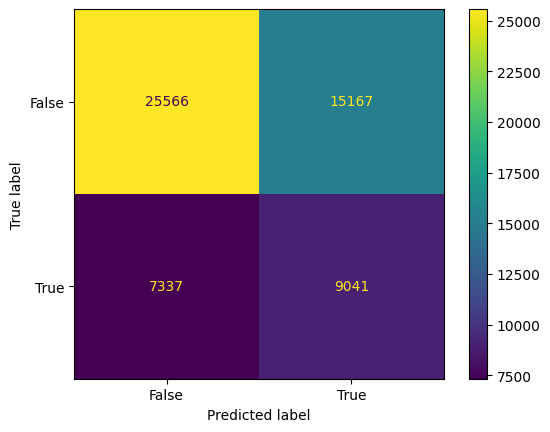

{'accuracy: 0.6059603228800056'}
{'sensitivity: 0.552021003785566'}
{'specificity: 0.6276483440944689'}
{'mcc: 0.16442975868641888'}


In [31]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

print({f'accuracy: {accuracy}'})
print({f'sensitivity: {sensitivity}'})
print({f'specificity: {specificity}'})
print({f'mcc: {mcc}'})

### Hyperparameter Tuning with GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

def mcc_scorer(y_test, y_pred):
    return matthews_corrcoef(y_test, y_pred)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

tuned_model = XGBClassifier()

mcc_scorer = make_scorer(mcc_scorer)

grid_search = GridSearchCV(estimator = tuned_model, param_grid = param_grid, cv = 3, scoring = mcc_scorer, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

### Model After Hyperparameter Tuning

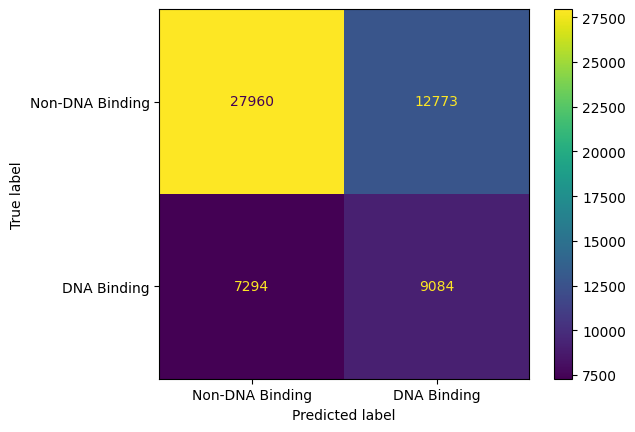

{'accuracy: 0.648631612123759'}
{'sensitivity: 0.5546464769813164'}
{'specificity: 0.6864213291434463'}
{'mcc: 0.22430728116823004'}


In [27]:
best_model = grid_search.best_estimator_
tuned_y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, tuned_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

print({f'accuracy: {accuracy}'})
print({f'sensitivity: {sensitivity}'})
print({f'specificity: {specificity}'})
print({f'mcc: {mcc}'})

### Using VarianceThreshold for feature selection

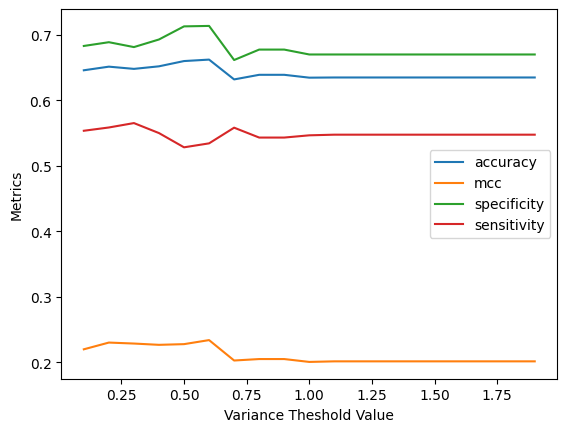

best threshold for variance for feature selection: 0.6
with corresponding metrics:
accuracy: 0.6622366969585544
sensitivity: 0.5343753816094762
specificity: 0.7136474111899442
mcc: 0.23404881731422722


In [21]:
import importlib
import feature_extraction
importlib.reload(feature_extraction)
from feature_extraction import *

mcc_arr = []
sensitivity_arr = []
specificity_arr = []
acccuracy_arr = []
variance_values = np.arange(0.1, 2, 0.1)

for val in variance_values:
    X_train, X_test = selecting_high_variance_features(X_train, X_test, val)

    model = XGBClassifier(learning_rate = 0.05, max_depth = 5, n_estimators = 100, colsample_bytree = 0.8, subsample = 1, gamma = 0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    acccuracy_arr.append(accuracy)
    sensitivity_arr.append(sensitivity)
    specificity_arr.append(specificity)
    mcc_arr.append(mcc)

plt.plot(variance_values, acccuracy_arr, label = 'accuracy')
plt.plot(variance_values, mcc_arr, label = 'mcc')
plt.plot(variance_values, specificity_arr, label = 'specificity')
plt.plot(variance_values, sensitivity_arr, label = 'sensitivity')

plt.xlabel('Variance Theshold Value')
plt.ylabel('Metrics')
plt.legend()

plt.show()

best_var_threshold = variance_values[mcc_arr.index(max(mcc_arr))]
acc = acccuracy_arr[mcc_arr.index(max(mcc_arr))]
sens = sensitivity_arr[mcc_arr.index(max(mcc_arr))]
spec = specificity_arr[mcc_arr.index(max(mcc_arr))]
mcc_best = max(mcc_arr)
print(f'best threshold for variance for feature selection: {best_var_threshold}')
print('with corresponding metrics:')
print(f'accuracy: {acc}')
print(f'sensitivity: {sens}')
print(f'specificity: {spec}')
print(f'mcc: {mcc_best}')